In [3]:
#!pip3 install torch==2.4.1+cu124 torchvision==0.19.1+cu124 torchaudio==2.4.1+cu124 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.4.1+cu124
True


In [3]:
import os
import cv2 as cv
import numpy as np
from insightface.app import FaceAnalysis
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras as keras

c:\Users\Ivan\anaconda3\envs\InsightFace_AS2_PT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.5 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [4]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.embeddings = []
        self.app = FaceAnalysis(name='buffalo_l', ctx_id=0)  
        self.app.prepare(ctx_id=0)  

    def extract_face_and_embedding(self, img):
        faces = self.app.get(img)
        if faces:
            face = faces[0]  
            bbox = face.bbox.astype(int)
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            face_img = img[y1:y2, x1:x2]
            face_resized = cv.resize(face_img, self.target_size)
            return face_resized, face.embedding
        else:
            return None, None

    def load_faces_and_embeddings(self, video_path):
        cap = cv.VideoCapture(video_path)
        frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, frame_count - 1, num=30, dtype=np.int32)

        extracted_faces = []
        embeddings = []
        for idx in frame_indices:
            cap.set(cv.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                face, embedding = self.extract_face_and_embedding(frame)
                if face is not None:
                    extracted_faces.append(face)
                    embeddings.append(embedding)
        
        cap.release()
        return extracted_faces, embeddings

    def load_classes(self):
        for video_name in os.listdir(self.directory):
            base_name = os.path.splitext(video_name)[0]
            video_path = os.path.join(self.directory, video_name)
            faces, embeddings = self.load_faces_and_embeddings(video_path)
            labels = [base_name for _ in range(len(faces))]
            print(f"Loaded successfully: {len(labels)} frames from {video_name}")
            self.X.extend(faces)
            self.Y.extend(labels)
            self.embeddings.extend(embeddings)
        
        return np.asarray(self.X), np.asarray(self.Y), np.asarray(self.embeddings)

    def plot_images(self):
        plt.figure(figsize=(18, 16))
        for num, image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y) // ncols + 1
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')

In [5]:
face_loader = FACELOADING(directory='Dataset/Final/Enroll')
X, Y, embeddings = face_loader.load_classes()
#face_loader.plot_images()
#plt.show()

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1'}, 'CPUExecutionProvider': {}}
find model: C:\Users\Ivan/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {

c:\Users\Ivan\anaconda3\envs\InsightFace_AS2_PT\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Loaded successfully: 30 frames from Chris Evans.mp4
Loaded successfully: 30 frames from Evangeline Lilly.mp4
Loaded successfully: 30 frames from Jamie Foxx.mp4
Loaded successfully: 30 frames from Keira Knightley.mp4
Loaded successfully: 30 frames from Nicole Kidman.mp4
Loaded successfully: 30 frames from Randall Park.mp4
Loaded successfully: 30 frames from Ryan Reynolds.mp4
Loaded successfully: 30 frames from Scarlett Johansson.mp4
Loaded successfully: 30 frames from Will Ferrell.mp4
Loaded successfully: 30 frames from Will Smith.mp4


In [6]:
np.savez_compressed('faces_embeddings_done.npz', EMBEDDED_X=embeddings, Y=Y)

In [7]:
data = np.load('faces_embeddings_done.npz')
known_embeddings = data['EMBEDDED_X']
known_labels = data['Y']

# Initialize InsightFace app
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0) 

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'device_id': '0', 'has_user_compute_stream': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'user_compute_stream': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'enable_cuda_graph': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'prefer_nhwc': '0', 'use_ep_level_unified_stream': '0', 'use_tf32': '1'}, 'CPUExecutionProvider': {}}
find model: C:\Users\Ivan/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {

# ResNet

In [8]:
base_model = ResNet152V2(
    weights='imagenet', 
    input_shape=(224, 224, 3),
    include_top=False) 

base_model.trainable = True 

for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False 

inputs = keras.Input(shape=(224, 224, 3), dtype=tf.uint8)
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)


model.load_weights("weights.best.ResNet.hdf5")

In [9]:
import threading

def preprocess_face_image(face_img):
    resized_face = cv.resize(face_img, (224, 224))  
    face_input = tf.expand_dims(resized_face, axis=0)  
    face_input = tf.cast(face_input, tf.float32)  
    face_input = tf.keras.applications.resnet_v2.preprocess_input(face_input)  
    return face_input

def recognize_face(embedding, known_embeddings, known_labels, face_threshold=0.4):
    distances = [cosine(embedding, known_emb) for known_emb in known_embeddings]
    min_distance = min(distances)
    if min_distance < face_threshold:
        index = distances.index(min_distance)
        return known_labels[index]
    return 'Unknown'

def process_video(video_path, dfd_threshold=0.3, face_threshold=0.4, fake_threshold=0.5, detect_deepfake=True,  display=False):
    cap = cv.VideoCapture(video_path)
    video_filename = os.path.basename(video_path)
    fps = cap.get(cv.CAP_PROP_FPS)
    frame_interval = int(fps / 1)  # process one frame per second
    total_frames = 0
    fake_frames = 0
    known_frames = 0
    unknown_frames = 0
    deepfake_results = []
    
    def deepfake_worker(frame, frame_number):
        img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        faces = app.get(img_rgb)  
        for face in faces:
            bbox = face.bbox.astype(int)
            x1, y1, x2, y2 = bbox
            face_img = img_rgb[y1:y2, x1:x2]
            preprocessed_face = preprocess_face_image(face_img)
            prediction = model.predict(preprocessed_face)[0][0]
            is_fake = prediction > dfd_threshold  
            deepfake_results.append((frame_number, is_fake, prediction))
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        total_frames += 1
        img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        faces = app.get(img_rgb)  
        
        for face in faces:
            bbox = face.bbox.astype(int)
            x1, y1, x2, y2 = bbox
            face_img = img_rgb[y1:y2, x1:x2]
            embedding = face.embedding
            label = recognize_face(embedding, known_embeddings, known_labels, face_threshold=face_threshold)
            if label == 'Unknown':
                unknown_frames += 1
            else:
                known_frames += 1
            
            if display:
                color = (0, 0, 255) if label == 'Unknown' else (0, 255, 0)
                cv.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv.putText(frame, label, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
        if detect_deepfake and total_frames % frame_interval == 0:
            # Start a thread for deepfake detection
            deepfake_thread = threading.Thread(target=deepfake_worker, args=(frame, total_frames))
            deepfake_thread.start()
            deepfake_thread.join() 
        
        if display:
            cv.putText(frame, f'Playing: {video_filename}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv.imshow('Face Recognition', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    if display:
        cv.destroyAllWindows()
    
    face_prediction = "Known" if known_frames >= unknown_frames else "Unknown"
    
    # Determine deepfake prediction if detection is enabled
    video_prediction = face_prediction  # default to face recognition result
    if detect_deepfake and deepfake_results:
        fake_frames = sum(1 for _, is_fake, _ in deepfake_results if is_fake)
        fake_percentage = fake_frames / len(deepfake_results)
        if fake_percentage > fake_threshold:
            video_prediction = "Fake"
        else:
            video_prediction = "Real"
    
    #final_prediction = face_prediction
    final_prediction = video_prediction

    # Prioritize face recognition if no known face is found
    #final_prediction = face_prediction if face_prediction == "Unknown" else video_prediction
    print(f"The video '{video_filename}' is classified as '{final_prediction}'")
    
    return final_prediction

# ResNet; DFD Treshold; DF% 0.1

In [10]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 0,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "ResNet_DFD_Obsah01"  
detect_deepfake_value = True 

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    dfd_threshold=thresh,
                    fake_threshold=0.1, 
                    detect_deepfake=detect_deepfake_value, 
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Fake" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt
The video 'DFL_1_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah01, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_1_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah01, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah01, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah01, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah01, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah01, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah01, Threshold: 0.00, Video: DFL_4_HQ.mp4, GT: 1,

# ResNet; DFD Treshold; DF% 0.25

In [ ]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 0,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "ResNet_DFD_Obsah025"  
detect_deepfake_value = True 

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    dfd_threshold=thresh,
                    fake_threshold=0.25, 
                    detect_deepfake=detect_deepfake_value, 
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Fake" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt
The video 'DFL_1_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah025, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_1_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah025, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah025, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah025, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah025, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah025, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah025, Threshold: 0.00, Video: DFL_4_HQ.mp4,

: 

# ResNet; DFD Treshold; DF% 0.5

In [10]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 0,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "ResNet_DFD_Obsah05"  
detect_deepfake_value = True 

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    dfd_threshold=thresh,
                    fake_threshold=0.5, 
                    detect_deepfake=detect_deepfake_value, 
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Fake" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt
The video 'DFL_1_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah05, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_1_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah05, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah05, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah05, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah05, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_LQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah05, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_HQ.mp4' is classified as 'Fake'
System: ResNet_DFD_Obsah05, Threshold: 0.00, Video: DFL_4_HQ.mp4, GT: 1,

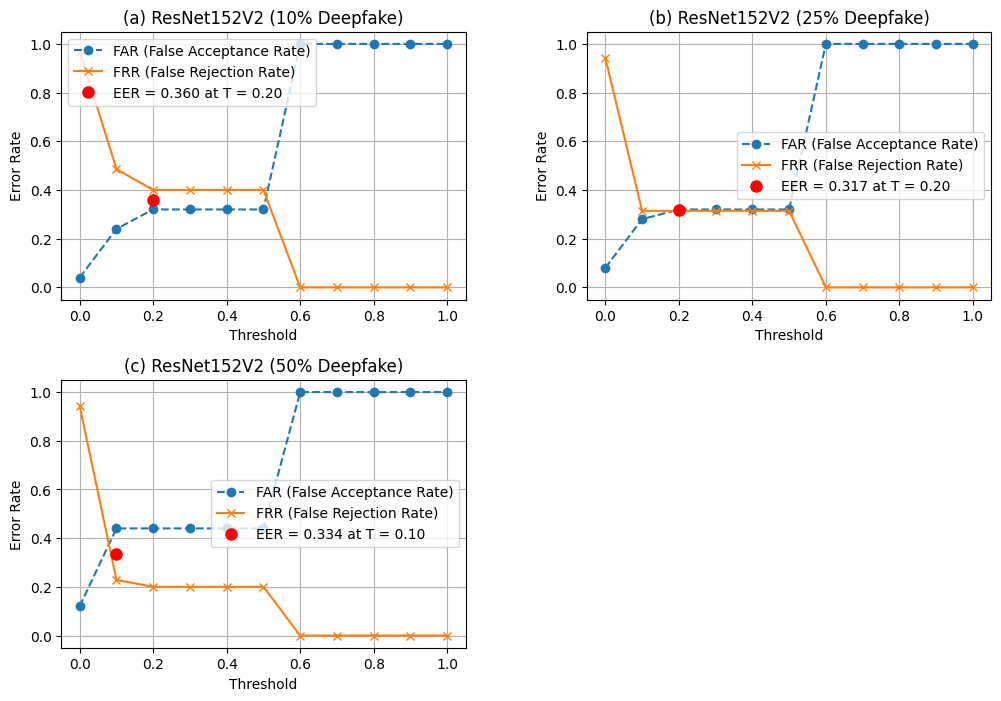

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths to CSV files for different face recognition systems
csv_paths = {
    "(a) ResNet152V2 (10% Deepfake)": "Dataset/Results/ResNet_DFD_Obsah01_results.csv",
    "(b) ResNet152V2 (25% Deepfake)": "Dataset/Results/ResNet_DFD_Obsah025_results.csv",
    "(c) ResNet152V2 (50% Deepfake)": "Dataset/Results/ResNet_DFD_Obsah05_results.csv"
}

num_systems = len(csv_paths)

# Define subplot grid (always 2x2 for consistency)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

# Iterate over each system and plot its results
for i, (system, csv_path) in enumerate(csv_paths.items()):
    df = pd.read_csv(csv_path)
    thresholds = np.sort(df['threshold'].unique())

    far_list, frr_list = [], []

    for thresh in thresholds:
        df_thresh = df[df['threshold'] == thresh]
        
        gt = df_thresh['gt'].values  # Ground truth labels (1 = fake, 0 = genuine)
        pred = df_thresh['prediction'].values  # Predicted labels

        # Compute FAR & FRR
        fake_count = np.sum(gt == 1)
        false_accepts = np.sum((gt == 1) & (pred == 0))
        far = false_accepts / fake_count if fake_count > 0 else 0

        genuine_count = np.sum(gt == 0)
        false_rejects = np.sum((gt == 0) & (pred == 1))
        frr = false_rejects / genuine_count if genuine_count > 0 else 0

        far_list.append(far)
        frr_list.append(frr)

    far_arr = np.array(far_list)
    frr_arr = np.array(frr_list)

    # Compute EER (Equal Error Rate)
    abs_diff = np.abs(far_arr - frr_arr)
    eer_index = np.argmin(abs_diff)
    eer_threshold = thresholds[eer_index]
    eer_value = (far_arr[eer_index] + frr_arr[eer_index]) / 2  

    # Plot FAR and FRR for the system
    ax = axes[i]
    ax.plot(thresholds, far_arr, label='FAR (False Acceptance Rate)', linestyle='--', marker='o')
    ax.plot(thresholds, frr_arr, label='FRR (False Rejection Rate)', linestyle='-', marker='x')

    ax.set_xlabel("Threshold")
    ax.set_ylabel("Error Rate")
    ax.set_title(system)
    ax.grid(True)

    # Mark EER
    ax.plot(eer_threshold, eer_value, 'ro', markersize=8, 
            label=f"EER = {eer_value:.3f} at T = {eer_threshold:.2f}")
    
    ax.legend()

# Hide unused subplots (but keep layout consistent)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove extra subplots without resizing others

# Adjust layout to keep all plots the same size
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()


In [13]:
video_directory = r'Dataset/Final/Fake/DFL_1_HQ.mp4'
process_video(video_directory, detect_deepfake=True, display=True)

The video 'DFL_1_HQ.mp4' is classified as 'Fake'


'Fake'

# ViT

In [9]:
import os
import threading
import cv2 as cv
import torch
from torchvision import transforms
from PIL import Image
from scipy.spatial.distance import cosine
import timm


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_large_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('best_vit_model.pth', map_location=device))
model.to(device)
model.eval()


def preprocess_face_image(face_img):
    pil_image = Image.fromarray(face_img)
    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    return input_tensor

def recognize_face(embedding, known_embeddings, known_labels, face_threshold):
    distances = [cosine(embedding, known_emb) for known_emb in known_embeddings]
    min_distance = min(distances)
    if min_distance < face_threshold:
        index = distances.index(min_distance)
        return known_labels[index]
    return 'Unknown'

def predict_face(input_tensor):
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        fake_prob = probabilities[0][0].item()  
    return fake_prob

def process_video(video_path, dfd_threshold=0.1, face_threshold=0.4, fake_threshold=0.25, detect_deepfake=True, display=False):
    cap = cv.VideoCapture(video_path)
    video_filename = os.path.basename(video_path)
    fps = cap.get(cv.CAP_PROP_FPS)
    frame_interval = int(fps / 1)  # process one frame per second
    total_frames = 0
    fake_frames = 0
    real_frames = 0
    known_frames = 0
    unknown_frames = 0
    deepfake_results = []

    def deepfake_worker(frame, frame_number):
        img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        faces = app.get(img_rgb)  
        for face in faces:
            bbox = face.bbox.astype(int)
            x1, y1, x2, y2 = bbox
            face_img = img_rgb[y1:y2, x1:x2]
            preprocessed_face = preprocess_face_image(face_img)
            prediction = predict_face(preprocessed_face)
            is_fake = prediction > dfd_threshold

            if is_fake:
                deepfake_results.append((frame_number, "Fake"))
            else:
                deepfake_results.append((frame_number, "Real"))

            #print(f"Frame {frame_number}: Deepfake detection: {'Fake' if is_fake else 'Real'} (Prediction: {prediction:.2f})")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        total_frames += 1
        img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        faces = app.get(img_rgb)  
        
        for face in faces:
            bbox = face.bbox.astype(int)
            x1, y1, x2, y2 = bbox
            face_img = img_rgb[y1:y2, x1:x2]
            embedding = face.embedding  
            label = recognize_face(embedding, known_embeddings, known_labels, face_threshold=face_threshold)
            
            if label == 'Unknown':
                unknown_frames += 1
            else:
                known_frames += 1
            
            # Perform deepfake detection on one frame per second
            if detect_deepfake and total_frames % frame_interval == 0 and label != 'Unknown':
                #and label != 'Unknown'
                deepfake_thread = threading.Thread(target=deepfake_worker, args=(frame, total_frames))
                deepfake_thread.start()
                deepfake_thread.join()

            # Determine Fake or Real based on collected results
            num_fake = sum(1 for _, status in deepfake_results if status == "Fake")
            num_real = sum(1 for _, status in deepfake_results if status == "Real")
            fake_percentage = num_fake / (num_fake + num_real) if (num_fake + num_real) > 0 else 0
            
            if fake_percentage > fake_threshold:
                label = "Fake"
                color = (255, 0, 0)  # Blue for Fake
            else:
                color = (0, 0, 255) if label == 'Unknown' else (0, 255, 0)  # Red for unknown, Green for known
            
            if display:
                cv.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv.putText(frame, label, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
        if display:
            cv.putText(frame, f'Playing: {video_filename}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv.imshow('Face Recognition', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    if display:
        cv.destroyAllWindows()
    
    face_prediction = "Known" if known_frames >= unknown_frames else "Unknown"
    
    # Determine deepfake prediction if detection is enabled
    video_prediction = face_prediction  
    if detect_deepfake and deepfake_results:
        num_fake = sum(1 for _, status in deepfake_results if status == "Fake")
        num_real = sum(1 for _, status in deepfake_results if status == "Real")
        fake_percentage = num_fake / (num_fake + num_real) if (num_fake + num_real) > 0 else 0

        if fake_percentage > fake_threshold:
            video_prediction = "Fake"
        else:
            video_prediction = "Real"
    
    #final_prediction = face_prediction
    #final_prediction = video_prediction

    # Prioritize face recognition if no known face is found
    final_prediction = face_prediction if face_prediction == "Unknown" else video_prediction
    print(f"The video '{video_filename}' is classified as '{final_prediction}'")
    
    return final_prediction

C:\Users\Ivan\AppData\Local\Temp\ipykernel_7992\87735820.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth', map_loca

In [20]:
video_directory = r'C:\Users\Ivan\Desktop\InsightFace\Dataset\Final\Original\id5_0001.mp4'
process_video(video_directory, detect_deepfake=True, display=True)

Frame 30: Deepfake detection: Real (Prediction: 0.03)
Frame 60: Deepfake detection: Real (Prediction: 0.00)
Frame 90: Deepfake detection: Real (Prediction: 0.00)
Frame 120: Deepfake detection: Real (Prediction: 0.01)
Frame 150: Deepfake detection: Real (Prediction: 0.04)
Frame 180: Deepfake detection: Real (Prediction: 0.01)
Frame 210: Deepfake detection: Fake (Prediction: 0.66)
Frame 240: Deepfake detection: Fake (Prediction: 0.58)
Frame 270: Deepfake detection: Real (Prediction: 0.01)
Frame 300: Deepfake detection: Real (Prediction: 0.00)
Frame 330: Deepfake detection: Real (Prediction: 0.00)
Frame 360: Deepfake detection: Real (Prediction: 0.00)
The video 'id5_0001.mp4' is classified as 'Real'


'Real'

In [77]:
video_directory = r'C:\Users\Ivan\Desktop\InsightFace\Dataset\Final\Fake\DFL_4_HQ.mp4'
process_video(video_directory, detect_deepfake=True, display=True)

Frame 30: Deepfake detection: Fake (Prediction: 1.00)
Frame 60: Deepfake detection: Fake (Prediction: 1.00)
Frame 90: Deepfake detection: Fake (Prediction: 1.00)
Frame 120: Deepfake detection: Fake (Prediction: 0.90)
Frame 150: Deepfake detection: Fake (Prediction: 1.00)
Frame 180: Deepfake detection: Fake (Prediction: 0.99)
Frame 210: Deepfake detection: Fake (Prediction: 0.89)
Frame 240: Deepfake detection: Fake (Prediction: 0.83)
Frame 270: Deepfake detection: Fake (Prediction: 0.99)
Frame 300: Deepfake detection: Fake (Prediction: 1.00)
Frame 300: Deepfake detection: Real (Prediction: 0.21)
The video 'DFL_4_HQ.mp4' is classified as 'Fake'


'Fake'

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

folder_to_gt = {
    'Original': 'Known',
    'Fake': 'Unknown'
}

root_dataset = 'Dataset/Final'
gt_labels = []
pred_labels = []

for folder in os.listdir(root_dataset):
    if folder not in folder_to_gt:
        print(f"Skipping folder: '{folder}'")
        continue

    folder_path = os.path.join(root_dataset, folder)
    if os.path.isdir(folder_path):
        gt = folder_to_gt.get(folder)
        # Assume video files end with .mp4
        video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
        for video_file in video_files:
            video_path = os.path.join(folder_path, video_file)
            final_prediction = process_video(video_path, detect_deepfake=True, display=False)
            gt_labels.append(gt)
            pred_labels.append(final_prediction)
            print(f"Video: {video_file}, Ground Truth: {gt}, Prediction: {final_prediction}")



Skipping folder: 'Enroll'


c:\Users\Ivan\anaconda3\envs\InsightFace_AS2_PT\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Frame 30: Deepfake detection: Real (Prediction: 0.08)
Frame 60: Deepfake detection: Fake (Prediction: 0.71)
Frame 90: Deepfake detection: Real (Prediction: 0.07)
Frame 120: Deepfake detection: Real (Prediction: 0.03)
Frame 150: Deepfake detection: Real (Prediction: 0.01)
Frame 180: Deepfake detection: Fake (Prediction: 0.18)
Frame 210: Deepfake detection: Fake (Prediction: 0.45)
Frame 240: Deepfake detection: Real (Prediction: 0.07)
Frame 270: Deepfake detection: Fake (Prediction: 0.12)
Frame 300: Deepfake detection: Fake (Prediction: 0.77)
Frame 330: Deepfake detection: Real (Prediction: 0.05)
Frame 360: Deepfake detection: Fake (Prediction: 0.10)
Frame 390: Deepfake detection: Fake (Prediction: 0.12)
Frame 420: Deepfake detection: Real (Prediction: 0.05)
Frame 450: Deepfake detection: Real (Prediction: 0.04)
The video 'DFL_1_HQ.mp4' is classified as 'Unknown'
Video: DFL_1_HQ.mp4, Ground Truth: Unknown, Prediction: Unknown
Frame 30: Deepfake detection: Fake (Prediction: 0.18)
Frame 60

In [54]:
cm = confusion_matrix(gt_labels, pred_labels, labels=["Known", "Unknown"])
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(gt_labels, pred_labels, labels=["Known", "Unknown"]))

Confusion Matrix:
[[ 9  1]
 [13 12]]

Classification Report:
              precision    recall  f1-score   support

       Known       0.41      0.90      0.56        10
     Unknown       0.92      0.48      0.63        25

    accuracy                           0.60        35
   macro avg       0.67      0.69      0.60        35
weighted avg       0.78      0.60      0.61        35



# InsightFace; Face Recognition Treshold

In [ ]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 1,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "InsightFace"  
detect_deepfake_value = False  

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    face_threshold=thresh, 
                    detect_deepfake=detect_deepfake_value, 
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Unknown" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt


c:\Users\Ivan\anaconda3\envs\InsightFace_AS2_PT\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


The video 'DFL_1_HQ.mp4' is classified as 'Unknown'
System: InsightFace, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_1_LQ.mp4' is classified as 'Unknown'
System: InsightFace, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_HQ.mp4' is classified as 'Unknown'
System: InsightFace, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_LQ.mp4' is classified as 'Unknown'
System: InsightFace, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_HQ.mp4' is classified as 'Unknown'
System: InsightFace, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_LQ.mp4' is classified as 'Unknown'
System: InsightFace, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_HQ.mp4' is classified as 'Unknown'
System: InsightFace, Threshold: 0.00, Video: DFL_4_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_LQ.mp4' is classified as 'Unknown'
System: InsightFace, Thr

EER: 0.180 at threshold 0.40


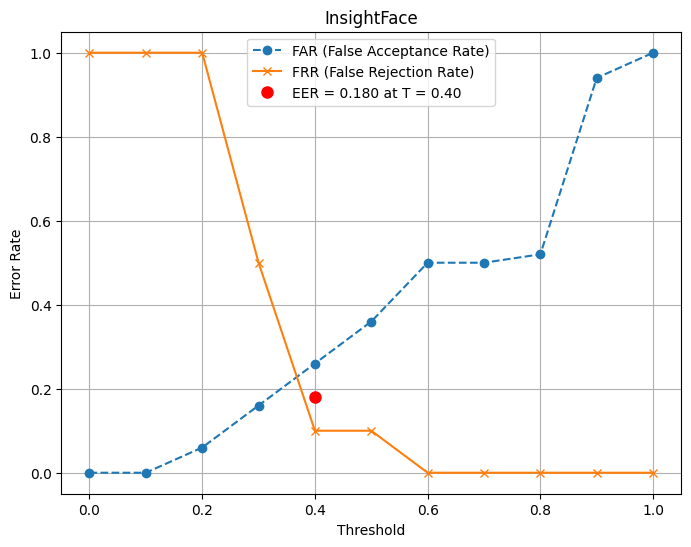

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


csv_path = "Dataset/Results/InsightFace_results.csv"
df = pd.read_csv(csv_path)

thresholds = np.sort(df['threshold'].unique())

far_list = []
frr_list = []

for thresh in thresholds:
    df_thresh = df[df['threshold'] == thresh]
    
    gt = df_thresh['gt'].values
    pred = df_thresh['prediction'].values

    fake_count = np.sum(gt == 1)
    false_accepts = np.sum((gt == 1) & (pred == 0))
    far = false_accepts / fake_count if fake_count > 0 else 0

    genuine_count = np.sum(gt == 0)
    false_rejects = np.sum((gt == 0) & (pred == 1))
    frr = false_rejects / genuine_count if genuine_count > 0 else 0

    far_list.append(far)
    frr_list.append(frr)

far_arr = np.array(far_list)
frr_arr = np.array(frr_list)

abs_diff = np.abs(far_arr - frr_arr)
eer_index = np.argmin(abs_diff)
eer_threshold = thresholds[eer_index]
eer_value = (far_arr[eer_index] + frr_arr[eer_index]) / 2  

print(f"EER: {eer_value:.3f} at threshold {eer_threshold:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, far_arr, label='FAR (False Acceptance Rate)', linestyle='--', marker='o')
plt.plot(thresholds, frr_arr, label='FRR (False Rejection Rate)', linestyle='-', marker='x')
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.title("InsightFace")
plt.grid(True)

plt.plot(eer_threshold, eer_value, 'ro', markersize=8, 
         label=f"EER = {eer_value:.3f} at T = {eer_threshold:.2f}")
plt.legend()

plt.show()

# ViT; DFD Treshold; DF% 0.1

In [ ]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 0,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "ViT_DFD_Obsah01"  
detect_deepfake_value = True 

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    dfd_threshold=thresh,
                    fake_threshold=0.1,  
                    detect_deepfake=detect_deepfake_value, 
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Fake" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt
The video 'DFL_1_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah01, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_1_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah01, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah01, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah01, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah01, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah01, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah01, Threshold: 0.00, Video: DFL_4_HQ.mp4, GT: 1, Prediction: 1
The vi

# ViT; DFD Treshold; DF% 0.25

In [10]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 0,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "ViT_DFD_Obsah025"  
detect_deepfake_value = True 

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    dfd_threshold=thresh,
                    fake_threshold=0.25,  
                    detect_deepfake=detect_deepfake_value, 
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Fake" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt


c:\Users\Ivan\anaconda3\envs\InsightFace_AS2_PT\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
c:\Users\Ivan\anaconda3\envs\InsightFace_AS2_PT\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


The video 'DFL_1_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah025, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_1_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah025, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah025, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah025, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah025, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah025, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah025, Threshold: 0.00, Video: DFL_4_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_LQ.mp4' is classified as 'Fake'
System: ViT_D

# ViT; DFD Treshold; DF% 0.5

In [11]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 0,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "ViT_DFD_Obsah05"  
detect_deepfake_value = True 

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    dfd_threshold=thresh,
                    fake_threshold=0.5,  
                    detect_deepfake=detect_deepfake_value, 
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Fake" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt
The video 'DFL_1_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah05, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_1_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah05, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah05, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah05, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah05, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_LQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah05, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_HQ.mp4' is classified as 'Fake'
System: ViT_DFD_Obsah05, Threshold: 0.00, Video: DFL_4_HQ.mp4, GT: 1, Prediction: 1
The vi

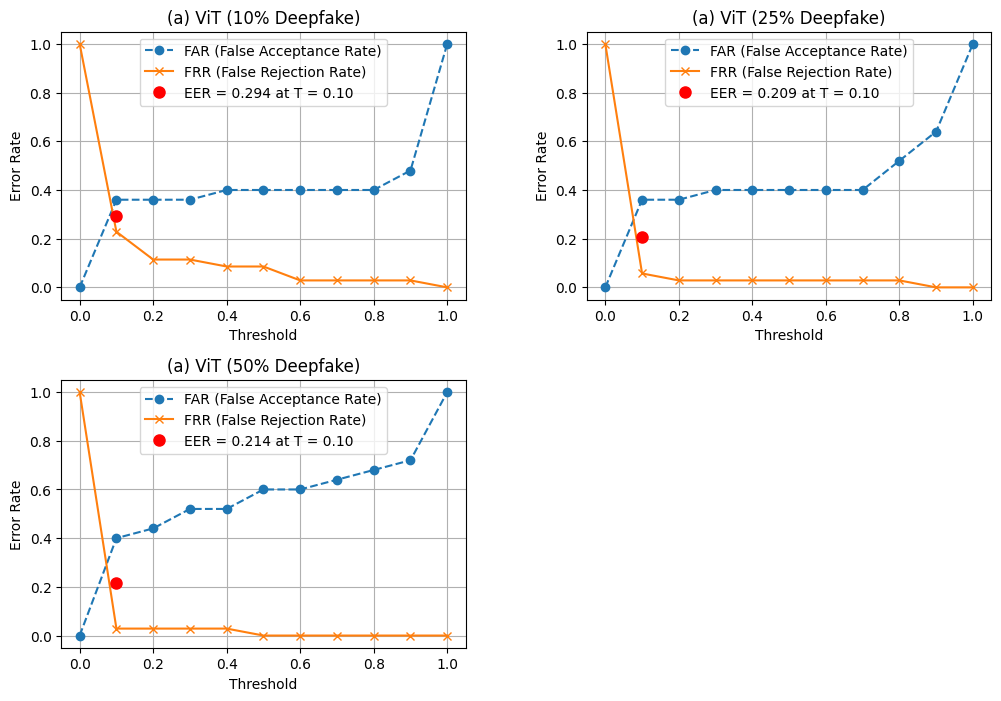

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths to CSV files for different face recognition systems
csv_paths = {
    "(a) ViT (10% Deepfake)": "Dataset/Results/ViT_DFD_Obsah01_results.csv",
    "(b) ViT (25% Deepfake)": "Dataset/Results/ViT_DFD_Obsah025_results.csv",
    "(c) ViT (50% Deepfake)": "Dataset/Results/ViT_DFD_Obsah05_results.csv"
}

num_systems = len(csv_paths)

# Define subplot grid (always 2x2 for consistency)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

# Iterate over each system and plot its results
for i, (system, csv_path) in enumerate(csv_paths.items()):
    df = pd.read_csv(csv_path)
    thresholds = np.sort(df['threshold'].unique())

    far_list, frr_list = [], []

    for thresh in thresholds:
        df_thresh = df[df['threshold'] == thresh]
        
        gt = df_thresh['gt'].values  # Ground truth labels (1 = fake, 0 = genuine)
        pred = df_thresh['prediction'].values  # Predicted labels

        # Compute FAR & FRR
        fake_count = np.sum(gt == 1)
        false_accepts = np.sum((gt == 1) & (pred == 0))
        far = false_accepts / fake_count if fake_count > 0 else 0

        genuine_count = np.sum(gt == 0)
        false_rejects = np.sum((gt == 0) & (pred == 1))
        frr = false_rejects / genuine_count if genuine_count > 0 else 0

        far_list.append(far)
        frr_list.append(frr)

    far_arr = np.array(far_list)
    frr_arr = np.array(frr_list)

    # Compute EER (Equal Error Rate)
    abs_diff = np.abs(far_arr - frr_arr)
    eer_index = np.argmin(abs_diff)
    eer_threshold = thresholds[eer_index]
    eer_value = (far_arr[eer_index] + frr_arr[eer_index]) / 2  

    # Plot FAR and FRR for the system
    ax = axes[i]
    ax.plot(thresholds, far_arr, label='FAR (False Acceptance Rate)', linestyle='--', marker='o')
    ax.plot(thresholds, frr_arr, label='FRR (False Rejection Rate)', linestyle='-', marker='x')

    ax.set_xlabel("Threshold")
    ax.set_ylabel("Error Rate")
    ax.set_title(system)
    ax.grid(True)

    # Mark EER
    ax.plot(eer_threshold, eer_value, 'ro', markersize=8, 
            label=f"EER = {eer_value:.3f} at T = {eer_threshold:.2f}")
    
    ax.legend()

# Hide unused subplots (but keep layout consistent)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove extra subplots without resizing others

# Adjust layout to keep all plots the same size
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()


# InsightFace + ViT Treshold

In [13]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 1,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "InsightFace_ViT"  
detect_deepfake_value = True  

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path,
                    dfd_threshold=thresh,
                    fake_threshold=0.25, 
                    detect_deepfake=detect_deepfake_value, 
                    display=False
                )
                
                prediction_val = 1 if final_prediction in ["Unknown", "Fake"] else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")


Skipping folder: 'Enroll' as it is not defined in folder_to_gt
The video 'DFL_1_HQ.mp4' is classified as 'Unknown'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_1_LQ.mp4' is classified as 'Unknown'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1


c:\Users\Ivan\anaconda3\envs\InsightFace_AS2_PT\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


The video 'DFL_2_HQ.mp4' is classified as 'Fake'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_2_LQ.mp4' is classified as 'Unknown'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_HQ.mp4' is classified as 'Fake'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_3_LQ.mp4' is classified as 'Unknown'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_HQ.mp4' is classified as 'Fake'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_4_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_4_LQ.mp4' is classified as 'Fake'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_4_LQ.mp4, GT: 1, Prediction: 1
The video 'DFL_5_HQ.mp4' is classified as 'Fake'
System: InsightFace_ViT, Threshold: 0.00, Video: DFL_5_HQ.mp4, GT: 1, Prediction: 1
The video 'DFL_5_LQ.mp4' is classified as 'Fake'
System: Insigh

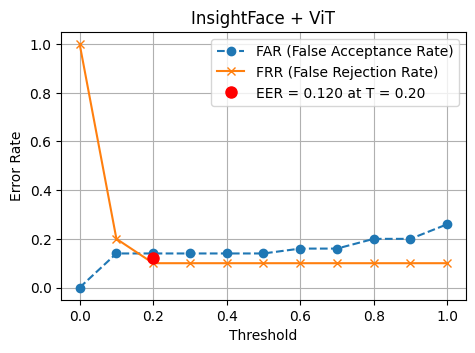

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


csv_paths = {
    "InsightFace + ViT": "Dataset/Results/InsightFace_ViT_results.csv",
}

num_systems = len(csv_paths)

# Define subplot grid (always 2x2 for consistency)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

# Iterate over each system and plot its results
for i, (system, csv_path) in enumerate(csv_paths.items()):
    df = pd.read_csv(csv_path)
    thresholds = np.sort(df['threshold'].unique())

    far_list, frr_list = [], []

    for thresh in thresholds:
        df_thresh = df[df['threshold'] == thresh]
        
        gt = df_thresh['gt'].values  # Ground truth labels (1 = fake, 0 = genuine)
        pred = df_thresh['prediction'].values  # Predicted labels

        # Compute FAR & FRR
        fake_count = np.sum(gt == 1)
        false_accepts = np.sum((gt == 1) & (pred == 0))
        far = false_accepts / fake_count if fake_count > 0 else 0

        genuine_count = np.sum(gt == 0)
        false_rejects = np.sum((gt == 0) & (pred == 1))
        frr = false_rejects / genuine_count if genuine_count > 0 else 0

        far_list.append(far)
        frr_list.append(frr)

    far_arr = np.array(far_list)
    frr_arr = np.array(frr_list)

    # Compute EER (Equal Error Rate)
    abs_diff = np.abs(far_arr - frr_arr)
    eer_index = np.argmin(abs_diff)
    eer_threshold = thresholds[eer_index]
    eer_value = (far_arr[eer_index] + frr_arr[eer_index]) / 2  

    # Plot FAR and FRR for the system
    ax = axes[i]
    ax.plot(thresholds, far_arr, label='FAR (False Acceptance Rate)', linestyle='--', marker='o')
    ax.plot(thresholds, frr_arr, label='FRR (False Rejection Rate)', linestyle='-', marker='x')

    ax.set_xlabel("Threshold")
    ax.set_ylabel("Error Rate")
    ax.set_title(system)
    ax.grid(True)

    # Mark EER
    ax.plot(eer_threshold, eer_value, 'ro', markersize=8, 
            label=f"EER = {eer_value:.3f} at T = {eer_threshold:.2f}")
    
    ax.legend()

# Hide unused subplots (but keep layout consistent)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove extra subplots without resizing others

# Adjust layout to keep all plots the same size
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()


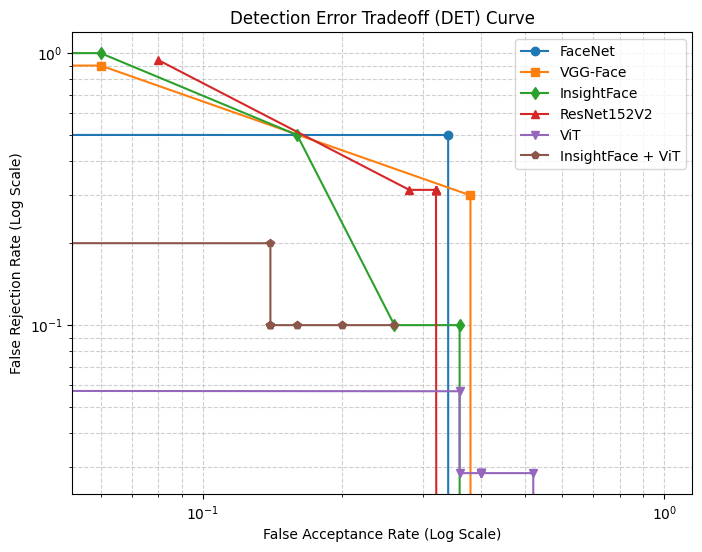

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define multiple system datasets
systems = {
    "FaceNet": "Dataset/Results/FaceNet_results.csv",
    "VGG-Face": "Dataset/Results/VGGFace_results.csv",
    "InsightFace": "Dataset/Results/InsightFace_results.csv",
    "ResNet152V2": "Dataset/Results/ResNet_DFD_Obsah025_results.csv",
    "ViT": "Dataset/Results/ViT_DFD_Obsah025_results.csv",
    "InsightFace + ViT": "Dataset/Results/InsightFace_ViT_results.csv",
}

plt.figure(figsize=(8, 6))

# Define colors and markers for different systems
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markers = ['o', 's', 'd', '^', 'v', 'p']

for (system_name, csv_path), color, marker in zip(systems.items(), colors, markers):
    df = pd.read_csv(csv_path)

    thresholds = np.sort(df['threshold'].unique())

    far_list = []
    frr_list = []

    # Compute FAR and FRR for each threshold
    for thresh in thresholds:
        df_thresh = df[df['threshold'] == thresh]
        
        gt = df_thresh['gt'].values
        pred = df_thresh['prediction'].values

        fake_count = np.sum(gt == 1)
        false_accepts = np.sum((gt == 1) & (pred == 0))
        far = false_accepts / fake_count if fake_count > 0 else 1e-6  # Avoid zero for log scale

        genuine_count = np.sum(gt == 0)
        false_rejects = np.sum((gt == 0) & (pred == 1))
        frr = false_rejects / genuine_count if genuine_count > 0 else 1e-6  # Avoid zero for log scale

        far_list.append(far)
        frr_list.append(frr)

    far_arr = np.array(far_list)
    frr_arr = np.array(frr_list)

    # Plot each system with different styles (NO EER points)
    plt.plot(far_arr, frr_arr, marker=marker, linestyle='-', color=color, label=system_name)

# Set log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel("False Acceptance Rate (Log Scale)")
plt.ylabel("False Rejection Rate (Log Scale)")
plt.title("Detection Error Tradeoff (DET) Curve")
plt.grid(True, which="both", linestyle='--', alpha=0.6)

plt.legend()
plt.show()
